# Diffusion Opinion

In [34]:
import os
import json
from tqdm import tqdm

import numpy as np
import random

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns


from weighted_opinion_diffusion import WeightedOpinionDiffusion
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

In [20]:
def plot_opinion_distribution(user_opinion, title="Distribuzione delle opinioni degli utenti", save=False, ax=None):
    """Crea un istogramma della distribuzione delle opinioni degli utenti."""
    if ax is None: fig, ax = plt.subplots()   
    
    opinions = list(user_opinion.values())

     # Creazione dell'istogramma
    counts, bins, patches = ax.hist(opinions, bins=20, edgecolor='black', log=True)

    # Colora le barre con una mappa di colori da blu (sinistra) a rosso (destra)
    cmap = plt.get_cmap("coolwarm")  # Blu → Rosso
    norm = plt.Normalize(vmin=0, vmax=1)  # Normalizza tra 0 e 1

    for patch, bin_left in zip(patches, bins[:-1]):
        color = cmap(norm(bin_left))  # Assegna il colore in base alla posizione
        patch.set_facecolor(color)

    ax.set_xlabel("Opinione")# (0 = pro-Biden, 1 = pro-Trump)")
    ax.set_ylabel("Numero di utenti")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.axvline(x=0.333, linestyle="--", color='black', alpha=0.7)
    ax.axvline(x=0.666, linestyle="--", color='black', alpha=0.7)
    
    if save: plt.savefig(os.path.join("plots", title))

    if ax is None: plt.show() # Serve per plot multipli

In [24]:
# Carica il network completo
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

# Salvo le opinoni inizializzatu su un array
opinions_init = np.array([full_graph_backbone.nodes[node]['opinion'] for node in full_graph_backbone.nodes()])

In [26]:
# Salvo i valori inizializzati durante il data collection per visualizzare la differenza nella diffusione
opinions_array = np.asarray(list(new_opinions.values()))
proTrump_init = opinions_array[opinions_array >= 0.666].size
proBiden_init = opinions_array[opinions_array <= 0.333].size
neutral_init = opinions_array[np.logical_and(opinions_array > 0.333, opinions_array < 0.666)].size

### Diffusione con media pesata [NON UTILIZZATO] 

Il peso corrisponde all'attributo weight dell'arco entrante moltiplicato per la compatibility (1 - differenza di opinioni)

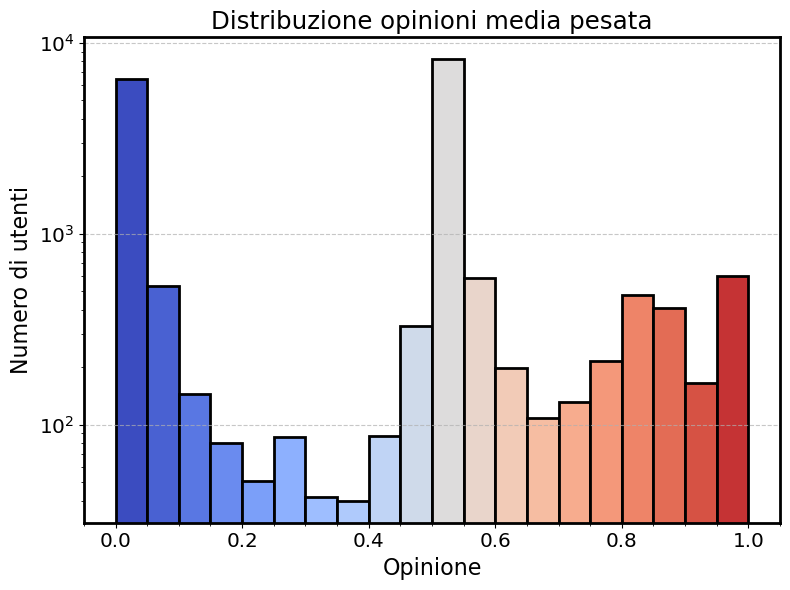

In [20]:
from weighted_opinion_diffusion_mean import WeightedOpinionDiffusionMean

iter = 200
random_opinion = False 
title = "Distribuzione opinioni media pesata"

# Carica il network completo
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

if random_opinion:
    # Sovrascrive attributo opinion con una variabile random in [0,1]
    for node in full_graph_backbone.nodes():
        full_graph_backbone.nodes[node]['opinion'] = random.uniform(0, 1)
    title = title + " (random init)"
    
# Inizializza il modello
model = WeightedOpinionDiffusionMean(full_graph_backbone, beta=0.5)

# Esegui iterazioni
proTrump = []
proBiden = []
neutral = []
for t in range(iter):
    new_opinions = model.iteration()
    opinions_array = np.asarray(list(new_opinions.values()))
    proTrump.append(opinions_array[opinions_array >= 0.6].size)
    proBiden.append(opinions_array[opinions_array <= 0.4].size)
    neutral.append(opinions_array[np.logical_and(opinions_array > 0.4, opinions_array < 0.6)].size)
    #print(f"Iterazione {t+1}")#

plot_opinion_distribution(new_opinions, title=title,  save=True)

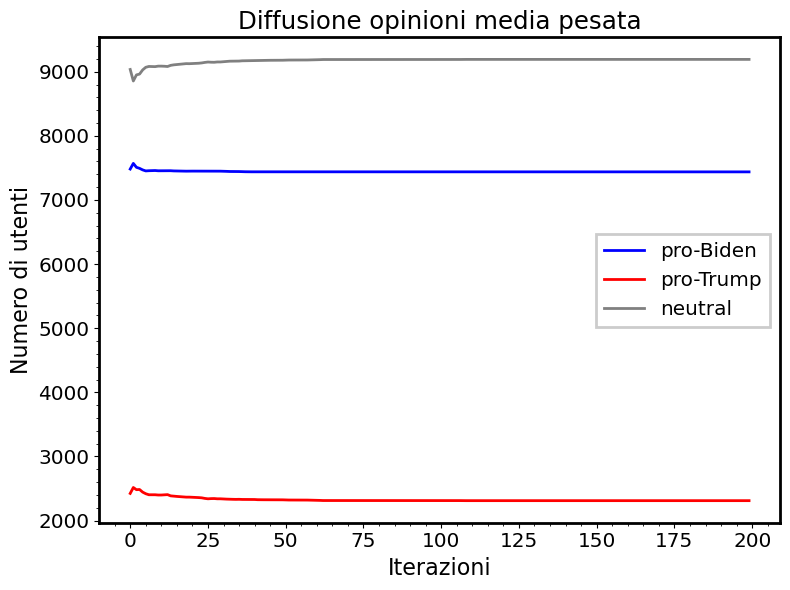

In [21]:
title = "Diffusione opinioni media pesata" 
if random_opinion: title = title + " (random init)"
plt.plot(range(iter), proBiden, color='b', label='pro-Biden')
plt.plot(range(iter), proTrump, color='r', label='pro-Trump')
plt.plot(range(iter), neutral, color='grey', label='neutral')
plt.xlabel("Iterazioni")
plt.ylabel("Numero di utenti")
plt.title(title)
plt.legend()
plt.savefig(os.path.join("plots", title))
plt.show()

## Distribuzione opinone con un solo nodo

Invece di fare la media pesata viene estratto randomicamente un nodo casuale tra i vicini entranti (ulteriori informazioni sul modello sono presenti nel file weighted_opinion_diffusion.py)

100%|███████████████████████████████████████| 1000/1000 [07:29<00:00,  2.22it/s]


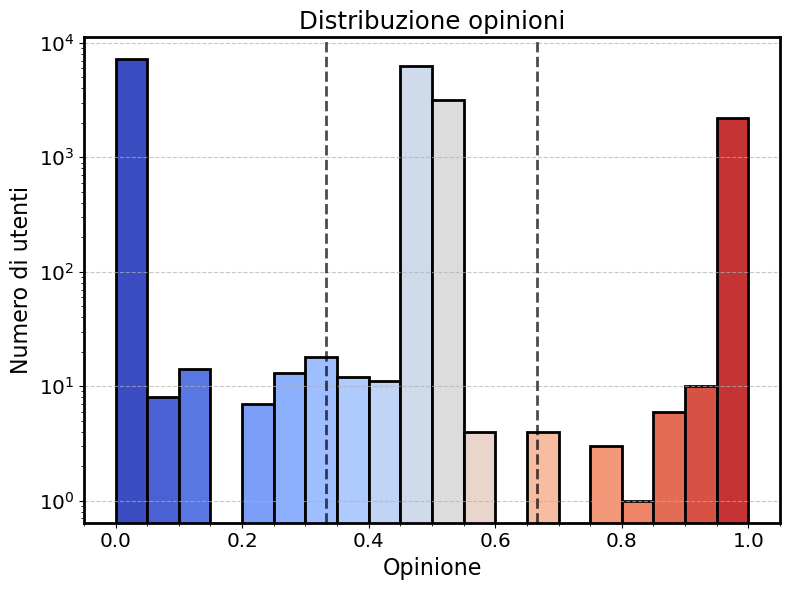

In [50]:
iter = 1000
random_opinion = False 
title = "Distribuzione opinioni"

# Carica il network completo
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

if random_opinion:
    # Sovrascrive attributo opinion con una variabile random in [0,1]
    for node in full_graph_backbone.nodes():
        full_graph_backbone.nodes[node]['opinion'] = random.uniform(0, 1)
    title += " (random init)"

model = WeightedOpinionDiffusion(full_graph_backbone, epsilon=0.5, bias=5)

#Ottenere lista ordinata dei nodi per mantenere coerenza nella matrice
nodes = list(full_graph_backbone.nodes())
num_nodes = len(nodes)

# Creare la matrice delle opinioni (num_users × iterazioni)
opinions_matrix = np.zeros((num_nodes, iter))

# Esegui iterazioni
proTrump = []
proBiden = []
neutral = []
for t in tqdm(range(iter)):
    new_opinions = model.iteration()

    # Salva le opinioni in una matrice
    for i, node in enumerate(nodes):
        opinions_matrix[i, t] = new_opinions[node]

    # Discretizza opinioni in tre categorie: pro-Trump, pro-Biden e Neutral
    opinions_array = np.asarray(list(new_opinions.values()))
    proTrump.append(opinions_array[opinions_array >= 0.666].size)
    proBiden.append(opinions_array[opinions_array <= 0.333].size)
    neutral.append(opinions_array[np.logical_and(opinions_array > 0.333, opinions_array < 0.666)].size)

plot_opinion_distribution(new_opinions, title=title,  save=True)

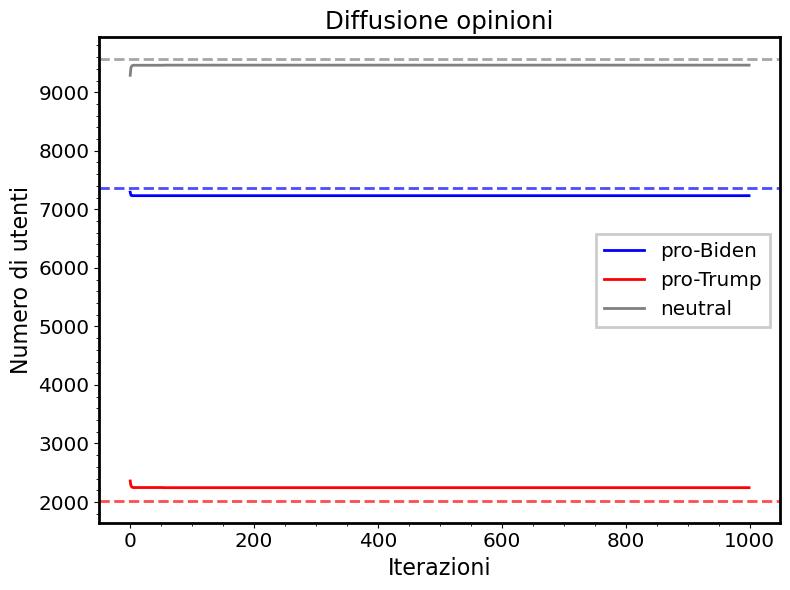

In [51]:
# Diffusione opinioni discretizzate, i valori partono dopo la prima iterazione
# La linea tratteggiata rappresenta l'inizializzazione fatta durante il data collection
title = "Diffusione opinioni" 
if random_opinion: title += " (random init)"
plt.axhline(y = proBiden_init, color='b', linestyle='--', alpha=0.7)
plt.axhline(y = proTrump_init, color='r', linestyle='--', alpha=0.7)
plt.axhline(y=neutral_init, color='grey', linestyle='--', alpha=0.7)
plt.plot(range(iter), proBiden, color='b', label='pro-Biden')
plt.plot(range(iter), proTrump, color='r', label='pro-Trump')
plt.plot(range(iter), neutral, color='grey', label='neutral')
plt.xlabel("Iterazioni")
plt.ylabel("Numero di utenti")
plt.title(title)
plt.legend()
plt.savefig(os.path.join("plots", title))
plt.show()

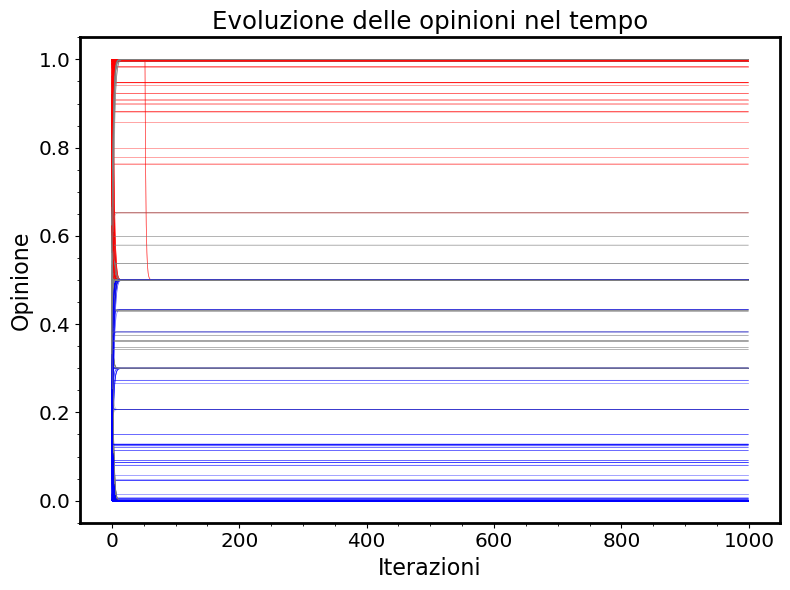

In [60]:
# Ottenere il numero di utenti e iterazioni
num_users, num_iters = opinions_matrix.shape
iterations = np.arange(num_iters)  # Array con i numeri delle iterazioni

# Ottenere i colori in base alla prima opinione
first_opinions = opinions_matrix[:, 0]
colors = ["blue" if op <= 0.333 else "red" if op >= 0.666 else "gray" for op in first_opinions]

# Creare il plot
#plt.figure(figsize=(12, 8))

# Disegnare una linea per ogni utente
for i in range(num_users):
    plt.plot(iterations, opinions_matrix[i, :], color=colors[i], alpha=0.5, linewidth=0.5)

# Etichette e titolo
plt.xlabel("Iterazioni")
plt.ylabel("Opinione")
title = "Evoluzione delle opinioni nel tempo"
if random_opinion: title += " (random init)"
plt.title(title)
#plt.ylim(0, 1)  # Limiti asse y per opinioni tra 0 e 1

"""
# Aggiungere legenda
from matplotlib.patches import Patch
legend_patches = [Patch(color="blue", label="Pro-Biden (≤ 0.333)"),
                  Patch(color="gray", label="Neutrali (0.333 - 0.666)"),
                  Patch(color="red", label="Pro-Trump (≥ 0.666)")]

plt.legend(handles=legend_patches, loc="best")
"""

plt.savefig(os.path.join("plots", title))
plt.show()

### Algorithmic Bias Model (NDlib)

In [55]:
# Gli algoritmi sopra cambiano il valore di 'opinion', bisogna ricaricare il network
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

real_graph = full_graph_backbone.to_undirected()

In [56]:
import itertools

# Stampa solo i primi 5 nodi con i loro attributi
for node, data in itertools.islice(real_graph.nodes(data=True), 5):
    print(f"Nodo {node}: {data}")

print('\n')
# Stampa solo i primi 5 archi con i loro attributi
for edge in itertools.islice(real_graph.edges(data=True), 5):
    print(edge)

Nodo Instr-FTO: {'opinion': 1.0, 'label': 'Instr-FTO'}
Nodo AutomaticDrop6236: {'opinion': 1.0, 'label': 'AutomaticDrop6236'}
Nodo Sufficient-Cat-5399: {'opinion': 1.0, 'label': 'Sufficient-Cat-5399'}
Nodo onearmedmonkey: {'opinion': 1.0, 'label': 'onearmedmonkey'}
Nodo Captainmanic: {'opinion': 1.0, 'label': 'Captainmanic'}


('Instr-FTO', 'AutomaticDrop6236', {'id': '0', 'weight': 2.0})
('Instr-FTO', 'Sufficient-Cat-5399', {'id': '15', 'weight': 3.0})
('Instr-FTO', 'onearmedmonkey', {'id': '2', 'weight': 2.0})
('Instr-FTO', 'Captainmanic', {'id': '3', 'weight': 2.0})
('Instr-FTO', 'Silent_Spell_3415', {'id': '61', 'weight': 2.0})


In [57]:
# Creiamo una mappatura da vecchi nomi a numeri
mapping = {node: i for i, node in enumerate(real_graph.nodes())}

# Rinominiamo i nodi
real_graph = nx.relabel_nodes(real_graph, mapping)

In [58]:
# Stampa solo i primi 5 nodi con i loro attributi
for node, data in itertools.islice(real_graph.nodes(data=True), 5):
    print(f"Nodo {node}: {data}")

print('\n')
# Stampa solo i primi 5 archi con i loro attributi
for edge in itertools.islice(real_graph.edges(data=True), 5):
    print(edge)

Nodo 0: {'opinion': 1.0, 'label': 'Instr-FTO'}
Nodo 1: {'opinion': 1.0, 'label': 'AutomaticDrop6236'}
Nodo 2: {'opinion': 1.0, 'label': 'Sufficient-Cat-5399'}
Nodo 3: {'opinion': 1.0, 'label': 'onearmedmonkey'}
Nodo 4: {'opinion': 1.0, 'label': 'Captainmanic'}


(0, 1, {'id': '0', 'weight': 2.0})
(0, 2, {'id': '15', 'weight': 3.0})
(0, 3, {'id': '2', 'weight': 2.0})
(0, 4, {'id': '3', 'weight': 2.0})
(0, 5, {'id': '61', 'weight': 2.0})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


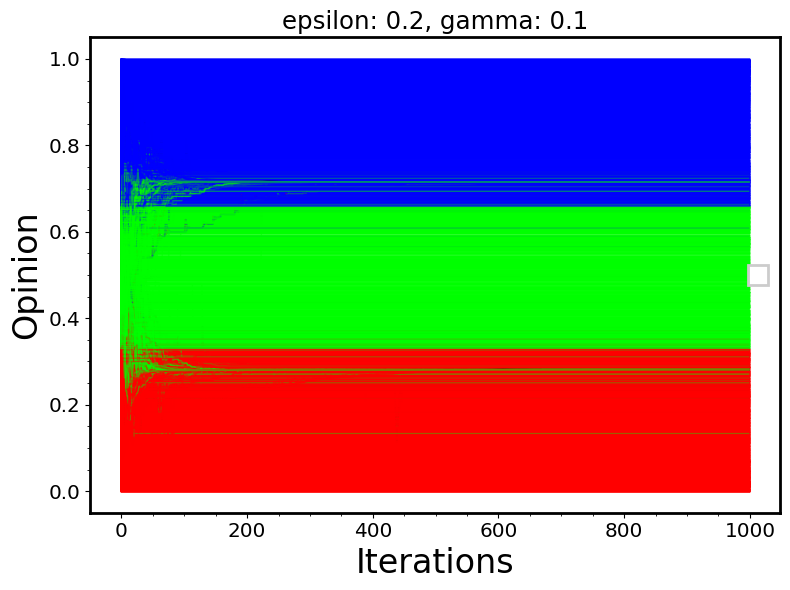

In [82]:
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op

model = op.AlgorithmicBiasModel(real_graph)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.2)
config.add_model_parameter("gamma", 0.1)  

# Creiamo un dizionario per memorizzare le opinioni iniziali
#initial_opinions = {node: real_graph.nodes[node].get("opinion", 0.5) for node in real_graph.nodes()}

# Forzare l'inizializzazione diretta dello stato del modello
#model.status = initial_opinions

model.set_initial_status(config)


# Simulation execution
iterations = model.iteration_bunch(1000)


from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
viz = OpinionEvolution(model, iterations)

viz.plot()
#plt.savefig(os.path.join("plots", "Algorithmic_Bias_Model_Opinion"))